### Price vs RSI

tl;dr
1. This cannot help one to decide when to sell a stock.
2. Based on history data, see how the price vary with respect to recent prices while RSI > 70.

Assumption:
1. The stock is good such that it is capable to raise (RSI > 70 sometimes).

In [1]:
# !pip install yfinance
# !pip install matplotlib
# !pip install pandas

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Definition:

Relative Strength Index
$$\text{RSI} = 100 - \frac{100}{1 + \text{RS}}$$

Relative Strength
$$\text{RS} = \frac{average\ gain\ over\ a\ period}{average\ loss\ over\ the\ same\ period}$$

where the period is typically 14 days.

There are various ways to take the average. A few of them are shown below.

1. Simple Moving Average (SMA). Average gain over a period = sum of gains in price over the period divide by period. Average loss over a period = sum of losses in price over the period divide by the period.
2. Smoothed Moving Average (SMMA). Recursively calculate the average $\mu_i = \frac{\mu_{i-1} (n-1) + x_i}{n}$ where $n$ is the period. The resulting RSI will respond slower than SMA. Usually, the RSI charts on the web has used some sort of smoothing.
3. Exponential Moving Average (EMA). The average is calculated where weighting for each older datum decreases exponentially.

Assuming SMA, selected RSI values are interpreted below,
1. $\text{RSI} = 0$ if no gain and all loss during the period.
2. $\text{RSI} = 0.5$, e.g. 7 day gain `$1` and 7 days loss `$1`.
3. $\text{RSI} = 1$ if all gain and no loss during the period.


In [3]:
def calculate_rsi_sma(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def smma(series, period):
    smma = series.copy()
    smma.iloc[:period] = series.iloc[:period].mean()  # seed with SMA
    for i in range(period, len(series)):
        smma.iloc[i] = ((smma.iloc[i - 1] * (period - 1)) + series.iloc[i]) / period
    return smma

def calculate_rsi_smma(data, period=14):
    delta = data.diff()

    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = smma(gain, period)
    avg_loss = smma(loss, period)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calculate_rsi_ema(data, period=14):
    # Calculate price change
    delta = data.diff()

    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Apply Exponential Moving Average
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def prepare_df(ticker, days=0, start_date='2024-09-01', end_date='2025-08-31', average_method='sma'):
    '''
    average_method: 
        'sma' for Simple Moving Average
        'smma' for Smoothing Moving Average
        'ema' for Exponential Moving Average
    '''
    if days > 0:
        df = yf.download(ticker, period=f'{days}d', auto_adjust=True, progress=False)
    else:
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
    
    if average_method == 'sma':
        df['RSI'] = calculate_rsi_sma(df['Close'])
    elif average_method == 'smma':
        df['RSI'] = calculate_rsi_smma(df['Close'])
    elif average_method == 'ema':
        df['RSI'] = calculate_rsi_ema(df['Close'])
    else:
        df['RSI'] = calculate_rsi_sma(df['Close'])
    return df

#### Prepare data, use RSI with SMMA

Calculate RSI using Smoothed Moving Average, SMMA.

Plot AAPL Close Price and RSI

In [4]:
df_aapl = prepare_df('AAPL', average_method='smma')

In [5]:
def plot_price_rsi(df):
    fig, ax1 = plt.subplots()
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
    x_interval = int(len(df) / 21 / 10)
    if x_interval == 0:
        x_interval = 1
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=x_interval))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    ax1.set_ylabel('Close Price', color='blue')
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['RSI'], label='RSI', color='g')
    ax2.set_ylabel('RSI', color='g')
    ax2.axhline(y=70, color='g', linestyle='-', label='RSI 70')
    ax2.axhline(y=30, color='g', linestyle='-', label='RSI 30')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper right')
    plt.show()

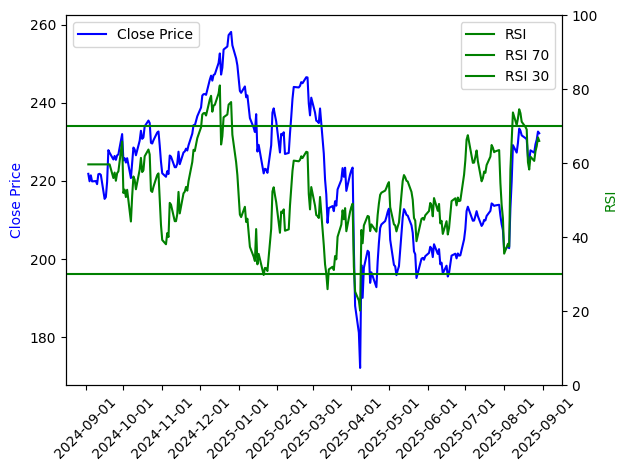

In [6]:
plot_price_rsi(df_aapl)

<img src="https://upload.wikimedia.org/wikipedia/commons/d/db/The_Magnificent_Seven_cast_publicity_photo.jpg" alt="magnificent 7" width="400">

In [7]:
SYMBOLS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
df_m7 = {}
for symbol in SYMBOLS:
    df_m7[symbol] = prepare_df(symbol, start_date='2022-09-01', end_date='2025-08-31', average_method='smma')  # 3 years data

#### Approach 1. Find RSI just before drop below 70. Compare the Close Price to max price around (e.g. -5 to +5 days)

Look at history data.  Find the Close Price on the last day of consecutive RSI >= 70 and the next day.  Compare them to the recently maximumn price, minimum price and average price.

In [8]:
LEFT_MIN = 21       # trade days per month
LEFT_AVERAGE = 21
LEFT_MAX = 5        # arbitrary take
RIGHT_MAX = 5       # arbitrary take

In [9]:
def get_price_average(df, start_index, end_index):
    return df.iloc[start_index:end_index]['Close'].mean().iloc[-1]

def get_price_min(df, start_index, end_index):
    return df.iloc[start_index:end_index]['Close'].min().iloc[-1]

def get_price_max(df, start_index, end_index):
    return df.iloc[start_index:end_index]['Close'].max().iloc[-1]


In [10]:
df_aapl_5_8 = df_aapl['2025-05-01':'2025-08-31']
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
print(df_aapl_5_8['2025-08-01':'2025-08-20'])
pd.reset_option('display.max_rows')
pd.reset_option('display.expand_frame_repr')

Price            Close        High         Low        Open     Volume        RSI
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL           
Date                                                                            
2025-08-01  202.150589  213.337890  201.271582  210.630955  104434500  35.461549
2025-08-04  203.119492  207.644355  201.451371  204.278165   75109300  38.126983
2025-08-05  202.689957  205.107211  201.930824  203.169408   44155100  37.389750
2025-08-06  213.008255  215.135845  205.356935  205.396898  108483100  58.266141
2025-08-07  219.780563  220.599641  216.334477  218.631873   90224800  66.226006
2025-08-08  229.090012  230.738135  219.001455  220.579666  113854000  73.662439
2025-08-11  227.179993  229.559998  224.759995  227.919998   61806100  70.245035
2025-08-12  229.649994  230.800003  227.070007  228.009995   55626200  72.050810
2025-08-13  233.330002  235.000000  230.429993  231.070007   69878500  74.530830
2025-08-14  232.779999  235.

Illustrate recently minimum price, average price, maximum price in a chart.

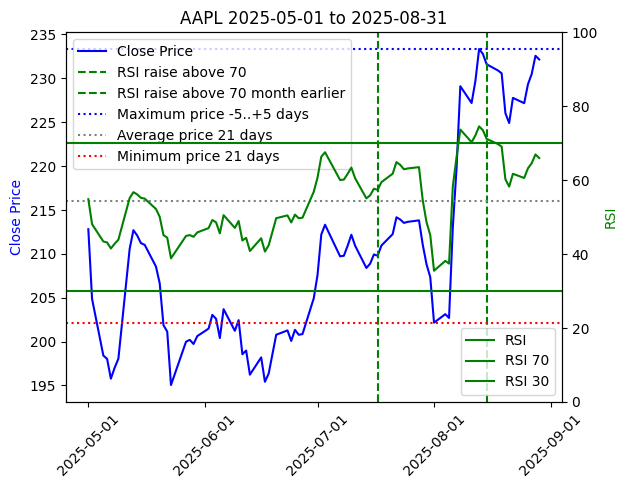

price min: 202.15, price average: 216.07, price max: 233.33
price close on 2025-08-15: 231.59, on next trade day: 230.89


In [11]:
# RSI just above 70 on 2025-08-15 and drop below 70 on 2025-08-18 (next trade day)
EVENT_DATE_STR = '2025-08-15'
df_aapl_5_8 = df_aapl['2025-05-01':'2025-08-31']
fig, ax1 = plt.subplots()
plt.title('AAPL 2025-05-01 to 2025-08-31')
ax1.plot(df_aapl_5_8.index, df_aapl_5_8['Close'], label='Close Price', color='blue')
event_date = pd.to_datetime(EVENT_DATE_STR)
event_date_month_earlier = df_aapl_5_8.index[df_aapl_5_8.index.get_loc(EVENT_DATE_STR) - LEFT_MIN]
ax1.axvline(x=event_date, color='g', linestyle='--', label='RSI raise above 70')
ax1.axvline(x=event_date_month_earlier, color='g', linestyle='--', label='RSI raise above 70 month earlier')
price_min = get_price_min(df_aapl_5_8, df_aapl_5_8.index.get_loc(EVENT_DATE_STR) - LEFT_MIN, df_aapl_5_8.index.get_loc(EVENT_DATE_STR) + 1)
price_average = get_price_average(df_aapl_5_8, df_aapl_5_8.index.get_loc(EVENT_DATE_STR) - LEFT_AVERAGE, df_aapl_5_8.index.get_loc(EVENT_DATE_STR) + 1)
price_max = get_price_max(df_aapl_5_8, df_aapl_5_8.index.get_loc(EVENT_DATE_STR) - LEFT_MAX, df_aapl_5_8.index.get_loc(EVENT_DATE_STR) + RIGHT_MAX + 1)
ax1.axhline(y=price_max, color='b', linestyle=':', label=f'Maximum price -{LEFT_MAX}..+{RIGHT_MAX} days')
ax1.axhline(y=price_average, color='grey', linestyle=':', label=f'Average price {LEFT_AVERAGE} days')
ax1.axhline(y=price_min, color='r', linestyle=':', label=f'Minimum price {LEFT_MIN} days')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
ax1.set_ylabel('Close Price', color='blue')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(df_aapl_5_8.index, df_aapl_5_8['RSI'], label='RSI', color='g')
ax2.set_ylabel('RSI', color='g')
ax2.axhline(y=70, color='g', linestyle='-', label='RSI 70')
ax2.axhline(y=30, color='g', linestyle='-', label='RSI 30')
ax2.set_ylim(0, 100)
ax2.legend(loc='lower right')
plt.show()
print(f'price min: {price_min:.2f}, price average: {price_average:.2f}, price max: {price_max:.2f}')
print('price close on {}: {:.2f}, on next trade day: {:.2f}'.format(
    EVENT_DATE_STR, 
    df_aapl_5_8.iloc[df_aapl_5_8.index.get_loc(EVENT_DATE_STR)].iloc[0], 
    df_aapl_5_8.iloc[df_aapl_5_8.index.get_loc(EVENT_DATE_STR) + 1].iloc[0]))

Above figure,
1. Area between 2 green dash vertical lines are used to calculate the price minimum and average price. 
2. The right green dash vertical line identifies 2025-08-15 where RSI >= 70 and RSI < 70 on the next trade day (2025-08-18).
3. Dot red horizontal line is price minimum
4. Dot grey horizontal line is price average
5. Dot blue horizontal line is price maximum between 2025-08-15 +/-5 days.
6. One can visualize the Close Price around 2025-08-15 with respect to the dot horizontal lines.

In [12]:
def find_price_when_rsi_drop_below_70(df, printout=False):
    index_close = df.columns.get_loc('Close').start
    index_rsi = df.columns.get_loc('RSI').start

    # skip beginning until RSI < 70
    for i_skip, row in df[max(LEFT_MIN, LEFT_AVERAGE, LEFT_MAX):].iterrows():   # skip enough data for calculate min, average, max
        if row.iloc[index_rsi] < 70:
            break
    
    count = 0
    price_div_max_sum = 0
    price_next_div_max_sum = 0
    price_div_min_sum = 0
    price_next_div_min_sum = 0
    price_div_average_sum = 0
    price_next_div_average_sum = 0
    if printout:
        print('count, date, price, price_next, price_min, price_average, price_max, price/max, price_next/max')
    for i, row in df[df.index.get_loc(i_skip):-1].iterrows():   # loop from i_skip to 2nd last row
        iloc_index = df.index.get_loc(i)
        if row.iloc[index_rsi] >= 70 and df.iloc[iloc_index+1].iloc[index_rsi] < 70:
            count += 1
            price = row.iloc[index_close]                           # price on date RSI >= 70
            price_next = df.iloc[iloc_index+1].iloc[index_close]    # price on next date RSI < 70
            price_min = get_price_min(df, iloc_index - LEFT_MIN, iloc_index + 1)
            price_average = get_price_average(df, iloc_index - LEFT_AVERAGE, iloc_index + 1)
            price_max = get_price_max(df, iloc_index - LEFT_MAX, iloc_index + RIGHT_MAX + 1)
            
            price_div_max_sum += price / price_max                  # the closer to 1, the better the price 
            price_next_div_max_sum += price_next / price_max        # similar for next trade day price

            price_div_min_sum += price / price_min
            price_next_div_min_sum += price_next / price_min

            price_div_average_sum += price / price_average
            price_next_div_average_sum += price_next / price_average

            if printout:
                print('{}, {}'.format(count, i.strftime('%Y-%m-%d')), end='')
                print(f', {price:.2f}, {price_next:.2f}, {price_min:.2f}, {price_average:.2f}, {price_max:.2f}', end='')
                print(f', {price / price_max:.2f}, {price_next / price_max:.2f}')
    return (count,
            price_div_max_sum / count, price_next_div_max_sum / count, 
            price_div_min_sum / count, price_next_div_min_sum / count, 
            price_div_average_sum / count, price_next_div_average_sum / count)

In [13]:
find_price_when_rsi_drop_below_70(df_m7['AAPL'], printout=True)

count, date, price, price_next, price_min, price_average, price_max, price/max, price_next/max
1, 2023-02-03, 152.35, 149.62, 123.28, 136.32, 152.50, 1.00, 0.98
2, 2023-02-07, 152.50, 149.81, 127.82, 138.78, 152.50, 1.00, 0.98
3, 2023-04-03, 164.11, 163.58, 146.66, 154.39, 164.11, 1.00, 1.00
4, 2023-06-02, 178.95, 177.60, 163.73, 171.67, 178.96, 1.00, 0.99
5, 2023-06-20, 182.97, 181.93, 169.67, 176.98, 185.98, 0.98, 0.98
6, 2023-06-23, 184.62, 183.23, 169.67, 178.47, 191.83, 0.96, 0.96
7, 2023-07-03, 190.34, 189.22, 175.86, 182.62, 191.83, 0.99, 0.99
8, 2023-07-19, 192.95, 191.00, 181.93, 187.48, 192.95, 1.00, 0.99
9, 2023-11-22, 189.70, 188.38, 165.27, 179.02, 189.84, 1.00, 0.99
10, 2023-12-08, 194.07, 191.56, 180.64, 187.96, 196.45, 0.99, 0.98
11, 2024-05-21, 191.24, 189.80, 164.66, 178.42, 191.24, 1.00, 0.99
12, 2024-06-05, 194.74, 193.36, 180.41, 187.81, 211.84, 0.92, 0.91
13, 2024-06-07, 195.75, 192.00, 181.44, 189.06, 213.00, 0.92, 0.90
14, 2024-06-18, 213.05, 208.47, 185.80, 196

(19,
 np.float64(0.9851723890208544),
 np.float64(0.9728843571809485),
 np.float64(1.1242854666262065),
 np.float64(1.1101187340582108),
 np.float64(1.0590048438200097),
 np.float64(1.0457166266719593))

In [14]:
print('Find RSI just before drop below 70')
print('ticker \tcount \tp/max \tpn/max \tp/min \tpn/min \tp/avg \tpn/avg')
for symbol in SYMBOLS:
    ret = find_price_when_rsi_drop_below_70(df_m7[symbol], printout=False)
    print(f'{symbol} \t{ret[0]:3} \t{ret[1]:.2f} \t{ret[2]:.2f} \t{ret[3]:.2f} \t{ret[4]:.2f} \t{ret[5]:.2f} \t{ret[6]:.2f}')

Find RSI just before drop below 70
ticker 	count 	p/max 	pn/max 	p/min 	pn/min 	p/avg 	pn/avg
AAPL 	 19 	0.99 	0.97 	1.12 	1.11 	1.06 	1.05
AMZN 	 13 	0.99 	0.97 	1.17 	1.14 	1.09 	1.07
GOOG 	 20 	0.99 	0.97 	1.14 	1.12 	1.08 	1.06
META 	 29 	0.97 	0.96 	1.20 	1.18 	1.09 	1.07
MSFT 	 26 	0.99 	0.98 	1.11 	1.09 	1.05 	1.04
NVDA 	 29 	0.97 	0.95 	1.29 	1.26 	1.13 	1.10
TSLA 	 12 	0.98 	0.93 	1.49 	1.42 	1.23 	1.16


- count is the number of consecutive RSI >= 70 regions.
- p/max is price on last RSI >= 70 divide by recently maximum price.
- pn/max is price on the next day (i.e. RS drops below 70) divide by recently maximum price.
- Similarly for the p/min, pn/min, p/avg and pn/avg.

Some observations:
1. Most of them have over 20 instances of RSI raise over 70 in last 3 years.
2. AAPL p/max is close to 1. However, the gain from p/avg is not impressive.
3. TSLA p/max 0.98 and pn/max 0.93 indicates price drop quickly. High p/avg means significant gain from recently average. 
4. Without rigorous definition, first 5 of Magnificent 7 have similar pattern of one type while NVDA and TSLA are of another type. 

#### Approach 2. Consider the price when RSI raise above 70

It may be difficult to predict if RSI is just before drop below 70.  As a alternative, can we use the event RSI just raise above 70?

Find RSI raise above 70. Compare the Close Price on this day (day 1) to max price around.  Repeat for day 2 etc while RSI is still above 70.  It is unlikely to sell on day 1. As RSI on day 1 is known, one may sell on day 2 or onward.

In [15]:
def find_price_when_rsi_raise_above_70(df, printout=False):
    index_close = df.columns.get_loc('Close').start
    index_rsi = df.columns.get_loc('RSI').start

    # skip beginning until RSI < 70
    for i_skip, row in df[max(LEFT_MIN, LEFT_AVERAGE, LEFT_MAX):].iterrows():   # skip enough data for calculate min, average, max
        if row.iloc[index_rsi] < 70:
            break
    
    count = 0
    consecutive_days = 0
    price_div_max_sum = 0
    price_next_div_max_sum = 0
    price_div_min_sum = 0
    price_next_div_min_sum = 0
    price_div_average_sum = 0
    price_next_div_average_sum = 0
    if printout:
        print('count, consecutive_days, date, price, price_min, price_average, price_max, price/max')
    for i, row in df[df.index.get_loc(i_skip):].iterrows(): 
        iloc_index = df.index.get_loc(i)
        if row.iloc[index_rsi] >= 70:
            if consecutive_days == 0:
                count += 1
            consecutive_days += 1
            
            price = row.iloc[index_close]
            price_min = get_price_min(df, iloc_index - LEFT_MIN, iloc_index + 1)
            price_average = get_price_average(df, iloc_index - LEFT_AVERAGE, iloc_index + 1)
            price_max = get_price_max(df, iloc_index - LEFT_MAX, iloc_index + RIGHT_MAX + 1)
            
            # printout may be used for speadsheet 
            if printout:
                print('{}, {}, {}'.format(count, consecutive_days, i.strftime('%Y-%m-%d')), end='')
                print(f', {price:.2f}, {price_min:.2f}, {price_average:.2f}, {price_max:.2f}', end='')
                print(f', {price / price_max:.2f}')

            # calculate day 1 and next day price divide by recent min, average and max
            if consecutive_days == 1: 
                price_next = df.iloc[iloc_index+1].iloc[index_close]
                
                price_div_max_sum += price / price_max
                price_next_div_max_sum += price_next / price_max

                price_div_min_sum += price / price_min
                price_next_div_min_sum += price_next / price_min
                
                price_div_average_sum += price / price_average
                price_next_div_average_sum += price_next / price_average
        else:
            consecutive_days = 0
            
    return (count, 
            price_div_max_sum / count, price_next_div_max_sum / count, 
            price_div_min_sum / count, price_next_div_min_sum / count, 
            price_div_average_sum / count, price_next_div_average_sum / count)


In [16]:
find_price_when_rsi_raise_above_70(df_m7['AAPL'], printout=True)

count, consecutive_days, date, price, price_min, price_average, price_max, price/max
1, 1, 2023-02-02, 148.72, 123.28, 135.00, 152.50, 0.98
1, 2, 2023-02-03, 152.35, 123.28, 136.32, 152.50, 1.00
2, 1, 2023-02-07, 152.50, 127.82, 138.78, 152.50, 1.00
3, 1, 2023-04-03, 164.11, 146.66, 154.39, 164.11, 1.00
4, 1, 2023-06-01, 178.10, 163.73, 171.10, 178.95, 1.00
4, 2, 2023-06-02, 178.95, 163.73, 171.67, 178.96, 1.00
5, 1, 2023-06-12, 181.76, 169.67, 174.27, 183.96, 0.99
5, 2, 2023-06-13, 181.29, 169.67, 174.71, 183.96, 0.99
5, 3, 2023-06-14, 181.92, 169.67, 175.22, 184.94, 0.98
5, 4, 2023-06-15, 183.96, 169.67, 175.85, 184.94, 0.99
5, 5, 2023-06-16, 182.88, 169.67, 176.42, 184.94, 0.99
5, 6, 2023-06-20, 182.97, 169.67, 176.98, 185.98, 0.98
6, 1, 2023-06-22, 184.94, 169.67, 177.91, 187.50, 0.99
6, 2, 2023-06-23, 184.62, 169.67, 178.47, 191.83, 0.96
7, 1, 2023-06-28, 187.16, 173.49, 180.55, 191.83, 0.98
7, 2, 2023-06-29, 187.50, 175.29, 181.18, 191.83, 0.98
7, 3, 2023-06-30, 191.83, 175.29, 1

(19,
 np.float64(0.9773609232722783),
 np.float64(0.9783111911108644),
 np.float64(1.1132672895823046),
 np.float64(1.1145386772859756),
 np.float64(1.0581465992407235),
 np.float64(1.0593055917363507))

In [17]:
print('Consider the price when RSI raise above 70')
print('ticker \tcount \tp/max \tpn/max \tp/min \tpn/min \tp/avg \tpn/avg')
for symbol in SYMBOLS:
    ret = find_price_when_rsi_raise_above_70(df_m7[symbol])
    print(f'{symbol} \t{ret[0]:3} \t{ret[1]:.2f} \t{ret[2]:.2f} \t{ret[3]:.2f} \t{ret[4]:.2f} \t{ret[5]:.2f} \t{ret[6]:.2f}')

Consider the price when RSI raise above 70
ticker 	count 	p/max 	pn/max 	p/min 	pn/min 	p/avg 	pn/avg
AAPL 	 19 	0.98 	0.98 	1.11 	1.11 	1.06 	1.06
AMZN 	 13 	0.99 	0.97 	1.17 	1.15 	1.09 	1.08
GOOG 	 21 	0.99 	0.98 	1.14 	1.13 	1.08 	1.07
META 	 29 	0.96 	0.97 	1.19 	1.20 	1.09 	1.10
MSFT 	 26 	0.99 	0.98 	1.11 	1.10 	1.05 	1.05
NVDA 	 29 	0.96 	0.96 	1.28 	1.29 	1.14 	1.14
TSLA 	 12 	0.93 	0.95 	1.42 	1.45 	1.20 	1.23


Observations:
1. Overall results are similar to the approach 1 and the entries of approach 1 and 2 are within 1%, except TSLA. One may use speadsheet to verify.
2. As approach 1, pn (price on next day is more practical to capture) and have similar values of the p results.

#### Use RSI with SMA

In [18]:
SYMBOLS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
df_m7 = {}
for symbol in SYMBOLS:
    df_m7[symbol] = prepare_df(symbol, start_date='2022-09-01', end_date='2025-08-31', average_method='sma')  # 3 years data

print('Find RSI just before drop below 70')
print('ticker \tcount \tp/max \tpn/max \tp/min \tpn/min \tp/avg \tpn/avg')
for symbol in SYMBOLS:
    ret = find_price_when_rsi_drop_below_70(df_m7[symbol], printout=False)
    print(f'{symbol} \t{ret[0]:3} \t{ret[1]:.2f} \t{ret[2]:.2f} \t{ret[3]:.2f} \t{ret[4]:.2f} \t{ret[5]:.2f} \t{ret[6]:.2f}')

print('')

print('Consider the price when RSI raise above 70')
print('ticker \tcount \tp/max \tpn/max \tp/min \tpn/min \tp/avg \tpn/avg')
for symbol in SYMBOLS:
    ret = find_price_when_rsi_raise_above_70(df_m7[symbol])
    print(f'{symbol} \t{ret[0]:3} \t{ret[1]:.2f} \t{ret[2]:.2f} \t{ret[3]:.2f} \t{ret[4]:.2f} \t{ret[5]:.2f} \t{ret[6]:.2f}')

Find RSI just before drop below 70
ticker 	count 	p/max 	pn/max 	p/min 	pn/min 	p/avg 	pn/avg
AAPL 	 34 	0.99 	0.97 	1.11 	1.10 	1.04 	1.03
AMZN 	 34 	0.99 	0.97 	1.14 	1.12 	1.06 	1.04
GOOG 	 39 	0.99 	0.97 	1.13 	1.12 	1.06 	1.04
META 	 39 	0.97 	0.96 	1.16 	1.15 	1.06 	1.05
MSFT 	 41 	0.99 	0.97 	1.11 	1.10 	1.05 	1.04
NVDA 	 35 	0.96 	0.94 	1.26 	1.24 	1.11 	1.09
TSLA 	 22 	0.97 	0.94 	1.31 	1.27 	1.12 	1.09

Consider the price when RSI raise above 70
ticker 	count 	p/max 	pn/max 	p/min 	pn/min 	p/avg 	pn/avg
AAPL 	 34 	0.98 	0.98 	1.11 	1.10 	1.05 	1.04
AMZN 	 34 	0.98 	0.98 	1.13 	1.12 	1.06 	1.06
GOOG 	 40 	0.98 	0.98 	1.12 	1.13 	1.06 	1.06
META 	 39 	0.97 	0.97 	1.16 	1.16 	1.07 	1.07
MSFT 	 41 	0.98 	0.98 	1.10 	1.11 	1.05 	1.05
NVDA 	 35 	0.95 	0.95 	1.25 	1.26 	1.11 	1.12
TSLA 	 22 	0.94 	0.95 	1.29 	1.29 	1.12 	1.13


#### Use RSA with EMA

In [19]:
SYMBOLS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
df_m7 = {}
for symbol in SYMBOLS:
    df_m7[symbol] = prepare_df(symbol, start_date='2022-09-01', end_date='2025-08-31', average_method='ema')  # 3 years data

print('Find RSI just before drop below 70')
print('ticker \tcount \tp/max \tpn/max \tp/min \tpn/min \tp/avg \tpn/avg')
for symbol in SYMBOLS:
    ret = find_price_when_rsi_drop_below_70(df_m7[symbol], printout=False)
    print(f'{symbol} \t{ret[0]:3} \t{ret[1]:.2f} \t{ret[2]:.2f} \t{ret[3]:.2f} \t{ret[4]:.2f} \t{ret[5]:.2f} \t{ret[6]:.2f}')

print('')

print('Consider the price when RSI raise above 70')
print('ticker \tcount \tp/max \tpn/max \tp/min \tpn/min \tp/avg \tpn/avg')
for symbol in SYMBOLS:
    ret = find_price_when_rsi_raise_above_70(df_m7[symbol])
    print(f'{symbol} \t{ret[0]:3} \t{ret[1]:.2f} \t{ret[2]:.2f} \t{ret[3]:.2f} \t{ret[4]:.2f} \t{ret[5]:.2f} \t{ret[6]:.2f}')

Find RSI just before drop below 70
ticker 	count 	p/max 	pn/max 	p/min 	pn/min 	p/avg 	pn/avg
AAPL 	 42 	0.99 	0.98 	1.10 	1.09 	1.05 	1.03
AMZN 	 40 	0.99 	0.97 	1.14 	1.12 	1.07 	1.05
GOOG 	 34 	0.99 	0.97 	1.14 	1.11 	1.07 	1.05
META 	 44 	0.98 	0.96 	1.18 	1.16 	1.09 	1.07
MSFT 	 49 	0.99 	0.98 	1.11 	1.10 	1.05 	1.04
NVDA 	 49 	0.97 	0.95 	1.25 	1.22 	1.11 	1.09
TSLA 	 28 	0.98 	0.95 	1.35 	1.30 	1.16 	1.11

Consider the price when RSI raise above 70
ticker 	count 	p/max 	pn/max 	p/min 	pn/min 	p/avg 	pn/avg
AAPL 	 42 	0.98 	0.98 	1.09 	1.09 	1.04 	1.04
AMZN 	 40 	0.98 	0.98 	1.13 	1.13 	1.07 	1.07
GOOG 	 35 	0.98 	0.98 	1.12 	1.13 	1.06 	1.06
META 	 44 	0.97 	0.97 	1.17 	1.17 	1.08 	1.08
MSFT 	 49 	0.99 	0.99 	1.11 	1.10 	1.05 	1.05
NVDA 	 49 	0.96 	0.96 	1.24 	1.24 	1.11 	1.11
TSLA 	 28 	0.95 	0.95 	1.30 	1.29 	1.13 	1.13


In [20]:
pd.__version__

'2.3.2'

In [21]:
yf.__version__

'0.2.65'